**Introduction:** 

We have been approached by the business to use machine learning to determine the claim risk associated with a policy.

The risk is defined as **the probability of the customer filing a claim within a year of purchasing the policy**.

The value of this work lies in the ability to estimate the probability of a claim, which enables the business to better understand each customer's risk profile. This insight can be used to assess the overall risk exposure and inform more accurate and strategic product pricing decisions.

**My Inital thoughts on challenges/requirements**
- Its clear from the brief that interpretabillity is paramount to the success of this task. 

- I aim to develop a model that is not only effective but also transparent and interpretable, enabling stakeholders to confidently make decisions based on its outcomes. Achieving this requires communicating technical results at varying levels of detail tailored to each audience involved in the decision-making process. **While I assume the model itself will be reviewed by technical staff, the outputs must also be accessible and meaningful to executive-level stakeholders.**

- The general idea is to build trust/confidence to show how ML methodology can be used and just as robust as stereotypical risk calculation methods. 




In [1]:
# Imports and loading the dataset
import pandas as pd 
import numpy as np
import os
from ydata_profiling import ProfileReport 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler




# Assuming this notebook is in the same directory as the synthetic data csv
# set working directory to the location of the current notebook
os.chdir(os.path.dirname(os.path.abspath("__file__")))

# CSV file starts with headers on row 0 and has no initially visible erros
# it is parsed well with default arguments for pd.read_csv() method
df = pd.read_csv("generated_synthetic_task_data.csv")

# Did a quick validation test on the opened csv file in excel to make sure 100% of 
# records and columns are loaded.
df.shape == (59806, 30)


# Create binary target class since we dont have this feature as default in the dataset
df["claim_made"] = df["claim_reported_date"].notnull().astype(int)




c:\Users\james\.conda\envs\flask_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1. Initial Data Exploration:** 

-Using ydata_profiling library to generate a .html dashboard to traverse a new dataset and learn about it. 

-This is a fantastic library that can generate a **consistent starting point** for any data project, especially when you are seeing a dataset for the first time. I would highly reccomend using this as part of an end to end project that requires strong attention to detail and hevay documentation (for example an FCA regulated business domain)

-**Any information that is worth noting or used to make a decision i will document in this notebook.**

-more info on ydata_profiling can be found here: https://github.com/ydataai/ydata-profiling it was previously known as "pandas profiling".
    


In [2]:

# Generate report and output as .html
# Using the .html is more consistent than using any form of widget to view the profile object directly in an IDE

# explorative = True just enables more features in the dashboard for analysis.
profile = ProfileReport(df, title="synthetic task data", explorative=True)
profile.to_file("synthetic_data_exploration_report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


**Summary of Dataset Observations and Assumptions**

1. `policy_start_date` and `policy_end_date` are constant values. It appears the dataset represents a snapshot of all 1-year policies starting on `2022-05-07`. Considering the objective is to estimate the probability of a claim within one year, this setup aligns well with our goal. It allows us to treat the full dataset as valid training data.  
   _Note: In a real-world scenario, mixed policy lengths would likely exist, which would introduce more complexity into claim probability estimation._

2. `other_policy_flag` is a constant value. While it's reasonable to assume this field indicates whether a customer holds multiple policies, we can ignore it for this exercise since it provides no variation or predictive value.

3. The dataset contains 623 duplicate rows (1.0%). These are true duplicates-identical across all features. Therefore, they can be safely removed without losing unique information.  
   _Assumption: `policy_identifier` acts as a primary key. Since we don't have confirmation of how policy data is structured at the business level, we assume duplicate rows do not carry additional meaning._

4. **Missing Values**
   - **4a.** `customer_education_level` has 3593 missing values (6.0%)  
     It's plausible these reflect real-world scenarios where education information couldn't be collected (e.g., declined to answer, not applicable). These records will not be dropped. Further analysis will be conducted to understand the patterns behind the missingness before applying any imputation.
   
   - **4b.** `customer_home_ownership` has 3602 missing values (6.0%)  
     These may represent customers who did not disclose or could not be matched to home ownership information. Removing them may introduce bias, so further exploration will be done to assess how best to handle them.
   
   - **4c.** `claim_reported_date` has 55,960 missing values (93.6%)  
     This likely indicates customers who did not make a claim. Given our goal is to identify claim probability within a year-and that a 6.4% claim rate aligns with the business's 5% target-this supports converting this field into a binary target: `claim_made = 1` if the date is present, `0` otherwise.

     Considering this field is responsbile for the target variable - it may be neccesery to implement methods to balance this dataset such as oversampling - duplicating records with claims (for logistic regression we can use class weighting). Will assess recall of the model to see if this is neccesery.

5. **Zero Values**
   - **5a.** `policy_renewal_number` has 8965 zeros (15.0%)  
     The value `0` is the most common, and likely indicates a new policy.  
     _Assumption: `policy_renewal_number == 0` means a new customer or new policy._  
     This is not considered an issue.  
     - Consider engineering a `is_new_policy` flag (`1` if renewal number is 0).  
     - Depending on model choice, binning this feature (e.g., `0`, `1–3`, `4–7`, `8+`) may improve interpretability.

   - **5b.** `policy_premium_band` has 25,500 zeros (42.6%)  
     The feature is highly skewed (~90% of values are between `0–2`), with a long tail extending up to `20`.  
     - Zeros here are not problematic.
     - Although stored as numeric, the distribution suggests it behaves categorically and possibly **ordinally**.
     - Further analysis will guide whether binning (e.g., `0–2`, `3–5`, `6+`) improves modeling.

   - **5c.** `location_score` has 3030 zeros (5.1%)  
     This appears to be a continuous numerical rating between `0–750`, with clustered values at common breakpoints (e.g., `93`, `150`, `225`).  
     - It has been flagged as highly correlated, suggesting strong predictive value.
     - Zeros could represent meaningful location risk or gaps in scoring-this requires caution.
     - Will consider engineering a flag (`location_score_is_zero`) to assess the impact of zeros on target variable.

   - **5d.** `customer_credit_one` has 15,250 zeros (25.5%)  
     This feature is difficult to interpret without context, but its naming suggests it represents a credit-related score.  
     - Only 9 unique values → suggests **binned** rather than continuous behavior.
     - Maximum value is `710`, which resembles a capped score (e.g., internal credit tiers).
     - The field likely behaves categorically and may reflect a proprietary risk score.  
     _Assumption: `customer_credit_one` is a binned credit score from one provider._  
     - Zeros may indicate customers for whom no credit data was available-possibly a meaningful signal of risk.
     - Will consider creating a binary flag (`credit_one_is_zero`) to test predictive power.

   - **5e.** `customer_credit_two` has 1234 zeros (2.1%)  
     Similar structure to `customer_credit_one`:
     - 10 distinct values  
     - Range: `0–999`, skewed toward high values (`773+`)  
     _Assumption: This is a second binned credit score from a different source or provider._  
     - Zeros are retained; they may signal genuine risk where data is unavailable.
     - Will mirror handling of credit one with a flag: `credit_two_is_zero`.

   - **5f.** `customer_credit_three` has 2143 zeros (3.6%)  
     Follows same pattern as credit one and two:
     - Only 10 distinct values, range: `0–1000`  
     - Common scores are `200`, `424`, `1000`, suggesting binned categories.  
     _Assumption: This represents a third scoring system or model._  
     - Zeros likely mean no score available, not missing data.  
     - Will consider creating a `credit_three_is_zero` flag to evaluate its relationship to claim probability.



### Assumptions Made

- `policy_renewal_number == 0` is treated as a new policy or customer. This assumption supports engineering a binary `is_new_policy` feature.

- `customer_credit_one`, `customer_credit_two`, and `customer_credit_three` represent credit scores from different sources or scoring models. The values appear to be bucketed into risk tiers.

- Missing values in `claim_reported_date` are assumed to mean that no claim was made. This has been used to create a binary target column: `claim_made`.

- Zero values in credit score features and `location_score` may indicate missing or unscored records, not necessarily a true value of zero. These are treated as potentially meaningful and not discarded.

---

### Areas Needing Further Analysis

- **Missing values in education and home ownership fields** need deeper analysis - specifically to identify any patterns in who is missing and whether those patterns are linked to claim behavior.

- **Distribution of claim rates by credit score bins** across all three credit features should be explored to confirm their predictive value and validate the ordinal assumption.

- **Binning strategy for features like `policy_premium_band` and `policy_renewal_number`** needs to be tested - especially to support model explainability.

- **Impact of zero values** in key features (e.g., credit scores, location score) needs to be evaluated further, possibly with engineered flags to capture presence vs. absence of score.

---

### Decisions Made So Far

- Duplicate rows have been removed.

- Constant columns have been excluded from the modeling process.

- Created binary target `claim_made` based on presence of `claim_reported_date`.

- No imputation has been applied yet for missing values - pending further exploration.

- Several features will be treated as ordinal/categorical rather than continuous (e.g., credit scores, premium bands).

- Engineered flag features for `credit_one_is_zero`, `credit_two_is_zero`, and `credit_three_is_zero` are being considered for modeling.


In [3]:
# Keeping a backup of original df for later use
df_original = df.copy()


In [4]:
# Dropping duplicates
print(f"Original shape: {df.shape}")
df = df.drop_duplicates()
print(f"New shape after dropping duplicates: {df.shape}")

# Removing constant columns
constant_cols = ['policy_start_date', 'policy_end_date', 'other_policy_flag']
df = df.drop(columns=constant_cols)
print(f"Dropped constant columns: {constant_cols}")

# Recheck duplicates after column removal - overkill but can sometimes be valuble
duplicate_rows = df[df.duplicated()]
print(f"Remaining duplicate rows after column drop: {duplicate_rows.shape[0]}")


Original shape: (59806, 31)
New shape after dropping duplicates: (59180, 31)
Dropped constant columns: ['policy_start_date', 'policy_end_date', 'other_policy_flag']
Remaining duplicate rows after column drop: 0


**Testing Missing values in education and home ownership fields by performing chi-squared test**

In [5]:


def test_binary_flag_association(df, feature, flag_type='missing', target='claim_made', alpha=0.05, return_values=False):
    # LLM GENERATED DOCSTRING
    """ 
    Performs a chi-squared test between a binary flag (missing or zero) and a binary target variable.

    Args:
        df (pd.DataFrame): The input dataframe.
        feature (str): The feature to assess.
        flag_type (str): Either 'missing' or 'zero'.
        target (str): Binary target column (default is 'claim_made').
        alpha (float): Significance level.
        return_values (bool): If True, returns chi2 and p-value.

    Returns (if return_values=True):
        tuple: (feature, chi2, p)
    """
    
    if flag_type == 'missing':
        flag_name = f'{feature}_missing'
        df[flag_name] = df[feature].isna()
    elif flag_type == 'zero':
        flag_name = f'{feature}_is_zero'
        df[flag_name] = df[feature] == 0
    else:
        raise ValueError("flag_type must be either 'missing' or 'zero'")

    contingency = pd.crosstab(df[flag_name], df[target])
    chi2, p, dof, _ = chi2_contingency(contingency)

    # LLM GENERATED PRINTING FORMAT
    print("\n" + "="*60)
    print(f"Chi-squared test: {flag_type.upper()} flag for '{feature}' vs '{target}'")
    print("-"*60)
    print(f"Chi2 statistic : {chi2:.4f}")
    print(f"p-value        : {p:.4f}")
    
    if p < alpha:
        print(f"✅ Statistically significant (p < {alpha})")
        print(f"→ '{flag_name}' is associated with '{target}'")
    else:
        print(f"⚠️ Not statistically significant (p ≥ {alpha})")
        print(f"→ '{flag_name}' is NOT associated with '{target}'")
    print("="*60)

    if return_values:
        return feature, chi2, p

   





# Testing missing education and home ownership
test_binary_flag_association(df, 'customer_education_level', flag_type='missing')
test_binary_flag_association(df, 'customer_home_ownership', flag_type='missing')




Chi-squared test: MISSING flag for 'customer_education_level' vs 'claim_made'
------------------------------------------------------------
Chi2 statistic : 0.2418
p-value        : 0.6229
⚠️ Not statistically significant (p ≥ 0.05)
→ 'customer_education_level_missing' is NOT associated with 'claim_made'

Chi-squared test: MISSING flag for 'customer_home_ownership' vs 'claim_made'
------------------------------------------------------------
Chi2 statistic : 5.3941
p-value        : 0.0202
✅ Statistically significant (p < 0.05)
→ 'customer_home_ownership_missing' is associated with 'claim_made'


**Outcome**: For predicting `claim_made`, the feature `customer_home_ownership` is likely to benefit from including a missingness flag, whereas `customer_education_level` is not.


---

### **Test 2: Validate Ordinality of Credit Features**

- **Objective:**  
  Assess whether credit score features exhibit **ordinal behavior** in relation to the target variable `claim_made`.

- **Approach:**  
  Plot average claim rate against each unique score value to visually inspect for **monotonic trends** (i.e., consistent increase or decrease).

- **Features Analyzed:**  
  - `customer_credit_one`  
  - `customer_credit_two`  
  - `customer_credit_three`

- **Interpretation Criteria:**  
  - If claim rate **rises or falls consistently** across score values → feature can be treated as **ordinal**.
  - If claim rate is **erratic** → consider treating the feature as **categorical** or **binning into broader groups**.
  - If certain values (e.g., 0) show distinctly different behavior → consider engineering a **flag** feature (e.g., `credit_one_is_zero`).

---


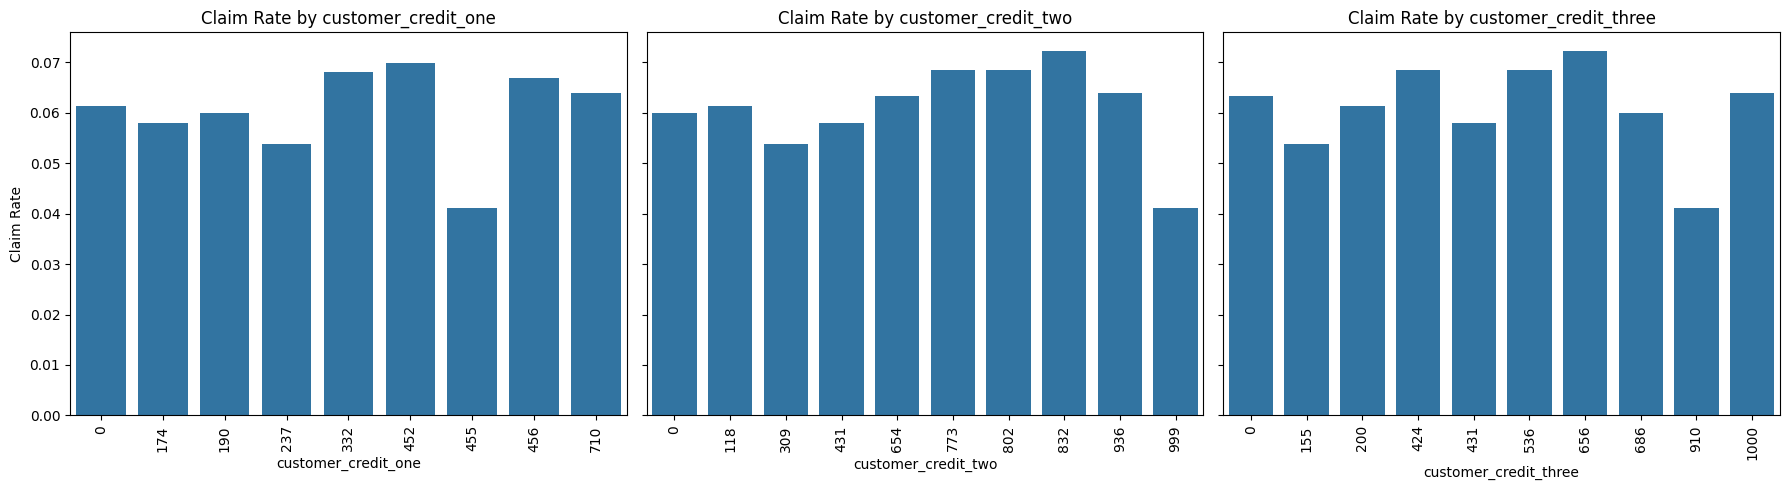

In [6]:

credit_cols = ['customer_credit_one', 'customer_credit_two', 'customer_credit_three']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, col in enumerate(credit_cols):
    sns.barplot(x=col, y='claim_made', data=df, ax=axes[i], errorbar=None)
    axes[i].set_title(f'Claim Rate by {col}')
    axes[i].set_ylabel('Claim Rate')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



**TEST 2 OUTCOME**
- After plotting and reviewing the claim rates across all values:

    - None of the three features showed a **consistent increasing or decreasing trend** in claim rate.

    - The patterns were often **irregular**, with sharp jumps and drops (e.g., `999` in `customer_credit_two` or `910` in `customer_credit_three`) that break any sense of order.

    - This suggests there is **no strong or reliable ordinal relationship** between score and claim outcome for any of these fields.

- There is an opportunity to explore these features further using statistical methods, but given the lack of clear structure and the likelihood of **diminishing returns**, I’ve chosen to move on at this stage.


---

### **Test 3: Decide on Binning Strategy**

- **Objective:**  
  Evaluate whether binning `policy_renewal_number` and `policy_premium_band` improves interpretability and model utility.

- **Features Considered:**  
  - `policy_renewal_number`  
  - `policy_premium_band`

- **Approach:**  
  - Plot the distribution of each feature to assess skewness or clustering.  
  - Explore whether certain **value ranges (bins)** exhibit different claim rates.  
  - Create **custom bin groups** and inspect claim rate across those bins.  




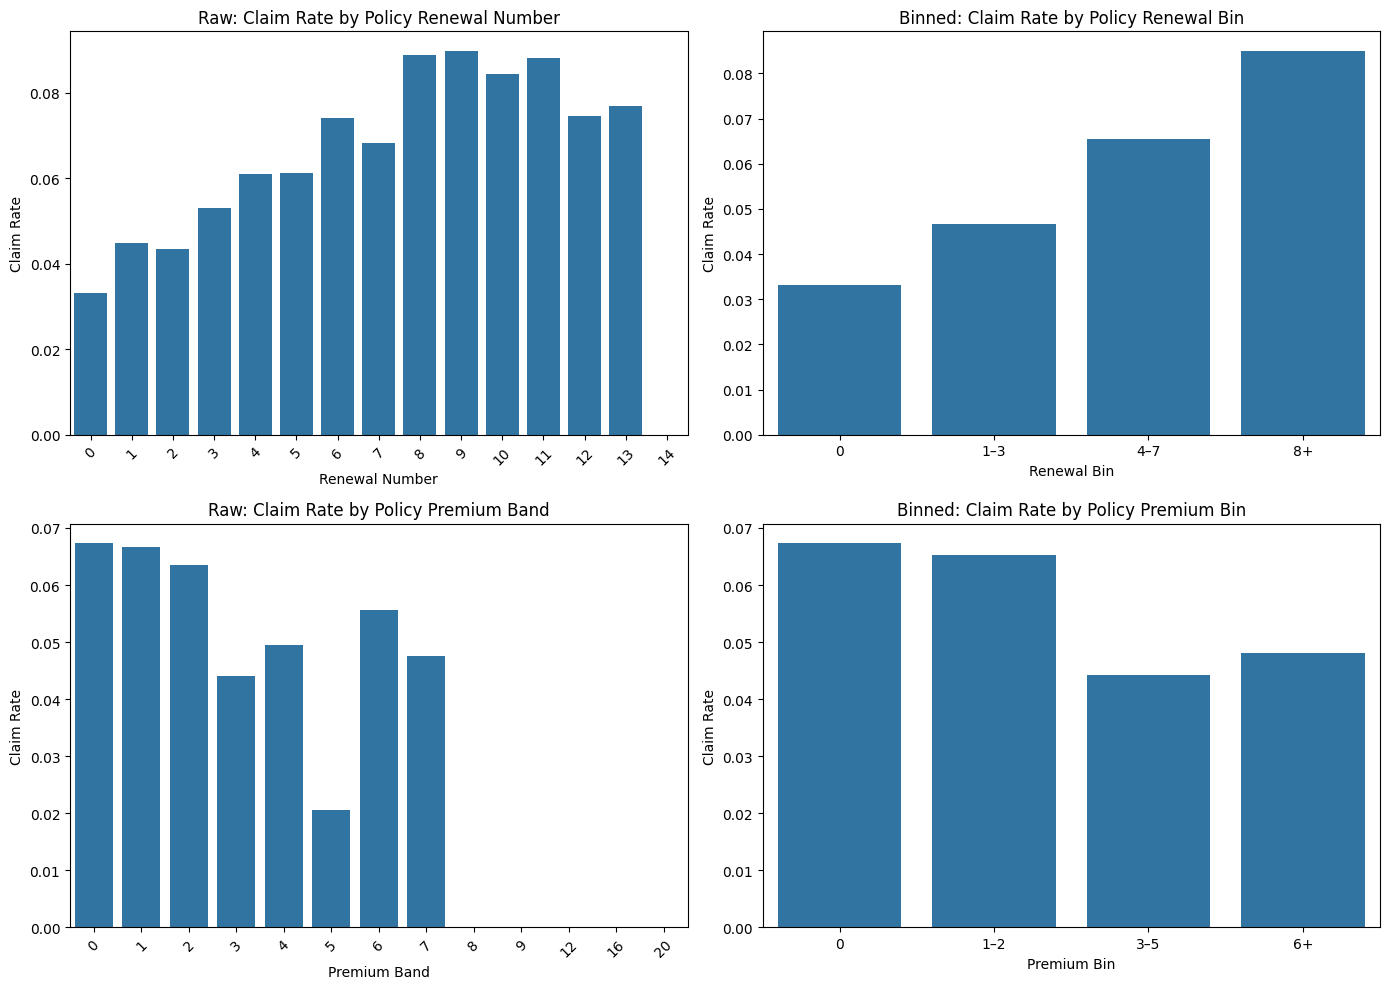

In [7]:
# Binning policy_renewal_number
df['renewal_bin'] = pd.cut(
    df['policy_renewal_number'],
    bins=[-1, 0, 3, 7, 14],
    labels=['0', '1–3', '4–7', '8+']
)

# Binning policy_premium_band
df['premium_bin'] = pd.cut(
    df['policy_premium_band'],
    bins=[-1, 0, 2, 5, 20],
    labels=['0', '1–2', '3–5', '6+']
)

plt.figure(figsize=(14, 10))

# policy_renewal_number 
plt.subplot(2, 2, 1)
sns.barplot(x='policy_renewal_number', y='claim_made', data=df, errorbar=None)
plt.title('Raw: Claim Rate by Policy Renewal Number')
plt.xlabel('Renewal Number')
plt.ylabel('Claim Rate')
plt.xticks(rotation=45)

# Binned: policy_renewal_number
plt.subplot(2, 2, 2)
sns.barplot(x='renewal_bin', y='claim_made', data=df, errorbar=None)
plt.title('Binned: Claim Rate by Policy Renewal Bin')
plt.xlabel('Renewal Bin')
plt.ylabel('Claim Rate')

# policy_premium_band
plt.subplot(2, 2, 3)
sns.barplot(x='policy_premium_band', y='claim_made', data=df, errorbar=None)
plt.title('Raw: Claim Rate by Policy Premium Band')
plt.xlabel('Premium Band')
plt.ylabel('Claim Rate')
plt.xticks(rotation=45)

# policy_premium_band 
plt.subplot(2, 2, 4)
sns.barplot(x='premium_bin', y='claim_made', data=df, errorbar=None)
plt.title('Binned: Claim Rate by Policy Premium Bin')
plt.xlabel('Premium Bin')
plt.ylabel('Claim Rate')

plt.tight_layout()
plt.show()




###  Test 3 Outcome: Binning Strategy for Policy Features

- I explored binning two numeric features: `policy_renewal_number` and `policy_premium_band`.

- Visually, both binned versions reveal slightly clearer trends in claim rates across grouped values compared to their raw forms. This suggests there may be meaningful structure that could benefit interpretability or modeling.

- However, it's not yet clear whether binning will improve actual model performance. Tree-based algorithms may learn similar splits on their own, and raw numeric features could still be more informative depending on the model used.

- At this stage, binning appears to be a valid and potentially valuable option for feature engineering. I will retain both the raw and binned versions and revisit this decision during model development based on performance metrics and explainability needs.


---

###  Test 4: Explore `location_score` Zeros

- **Objective:**  
  Determine whether a `location_score` value of `0` represents meaningful information (e.g., missing, defaulted, or high-risk locations) or whether it fits naturally into the rest of the score distribution.

- **Feature:**  
  `location_score` - a numeric variable, likely a geographic risk indicator ranging from 0 to 750.

- **Approach:**  
  - Create a binary flag: `location_score_is_zero` to isolate zero-value records.
  - Compare average claim rates for zero vs non-zero scores to detect any difference in behavior.
  - Visualize the distribution of `location_score` to understand where 0 falls relative to the rest of the data.

- **Next Step:**  
  If the 0s show significantly different claim behavior, I may retain the binary flag as a separate feature. If not, it may be safe to leave them in the main numeric distribution without further modification.



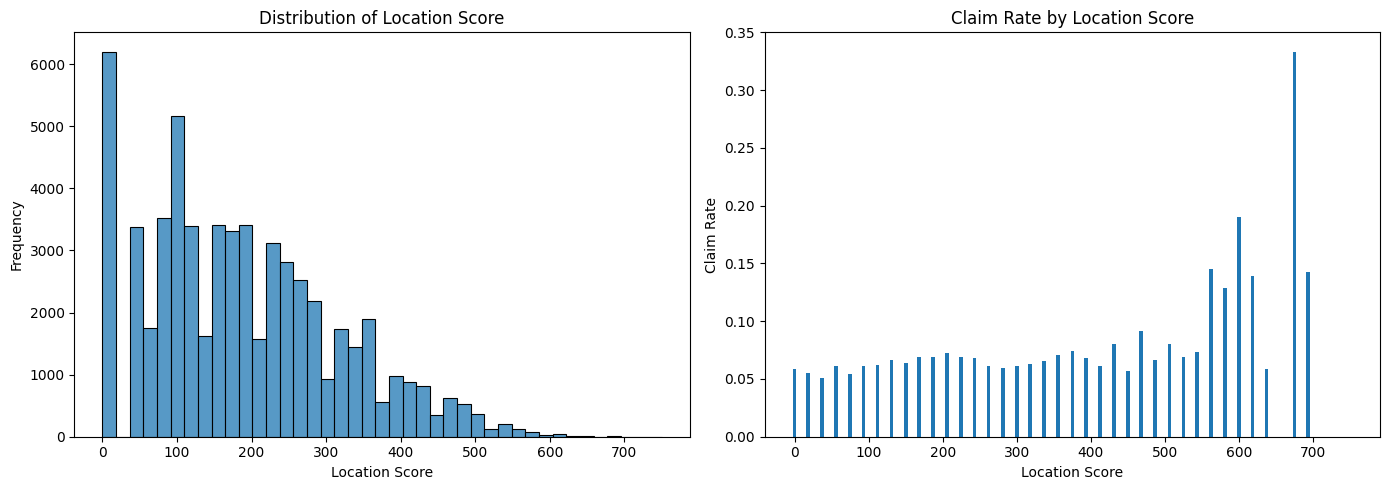

In [8]:

# Group claim rates by location_score
claim_rate_by_loc = df.groupby('location_score')['claim_made'].mean().reset_index()

# Plot
plt.figure(figsize=(14, 5))

# Plot Distribution (Histogram)
plt.subplot(1, 2, 1)
# bins = 41 because 41 distinct values
sns.histplot(df['location_score'], bins=41)
plt.title("Distribution of Location Score")
plt.xlabel("Location Score")
plt.ylabel("Frequency")

# Plot Claim Rate (Matplotlib)
plt.subplot(1, 2, 2)
plt.bar(claim_rate_by_loc['location_score'], claim_rate_by_loc['claim_made'], width=5)
plt.title("Claim Rate by Location Score")
plt.xlabel("Location Score")
plt.ylabel("Claim Rate")
plt.xticks(ticks=[0, 100, 200, 300, 400, 500, 600, 700], rotation=0)

plt.tight_layout()
plt.show()


### Test 4: Explore `location_score` Zeros – Outcome

- When plotting the distribution using `bins=41`, there is a clear **frequency peak at `location_score == 0`**, meaning a notable number of customers have this score.

- However, when plotting the **claim rate by location score**, `0` does **not behave differently** compared to surrounding values - its claim rate is consistent with scores like `18`, `37`, `75`, and `93`.

- This suggests that while `0` is common, it does **not appear to represent missing data or carry unique predictive behavior** on its own.

- Based on this, I won’t flag `0` as a separate category. Instead, `location_score` will be treated as a standard continuous feature going forward. If it proves important later (e.g. via model performance or feature importance), I may revisit.

---


### Test 5: Statistical Impact of Zero Values

**Objective:**  
Evaluate whether the presence of zero values in key numeric features has a statistically significant association with claim outcomes.

**Features Tested:**

- `policy_renewal_number`
- `policy_premium_band`
- `location_score`
- `customer_credit_one`
- `customer_credit_two`
- `customer_credit_three`

**Method:**  
For each feature, we:
1. Created a binary flag (`feature_is_zero`) indicating whether the value was zero.
2. Ran a **Chi-squared test** between the flag and the binary target variable (`claim_made`).
3. Used a significance threshold of **α = 0.05** to determine if the association was statistically meaningful.

This test helps us understand whether zero values contain a real signal or can be treated as ordinary numerical values.


Chi-squared test: ZERO flag for 'policy_renewal_number' vs 'claim_made'
------------------------------------------------------------
Chi2 statistic : 163.8895
p-value        : 0.0000
✅ Statistically significant (p < 0.05)
→ 'policy_renewal_number_is_zero' is associated with 'claim_made'

Chi-squared test: ZERO flag for 'policy_premium_band' vs 'claim_made'
------------------------------------------------------------
Chi2 statistic : 9.0876
p-value        : 0.0026
✅ Statistically significant (p < 0.05)
→ 'policy_premium_band_is_zero' is associated with 'claim_made'

Chi-squared test: ZERO flag for 'location_score' vs 'claim_made'
------------------------------------------------------------
Chi2 statistic : 1.2523
p-value        : 0.2631
⚠️ Not statistically significant (p ≥ 0.05)
→ 'location_score_is_zero' is NOT associated with 'claim_made'

Chi-squared test: ZERO flag for 'customer_credit_one' vs 'claim_made'
------------------------------------------------------------
Chi2 statistic

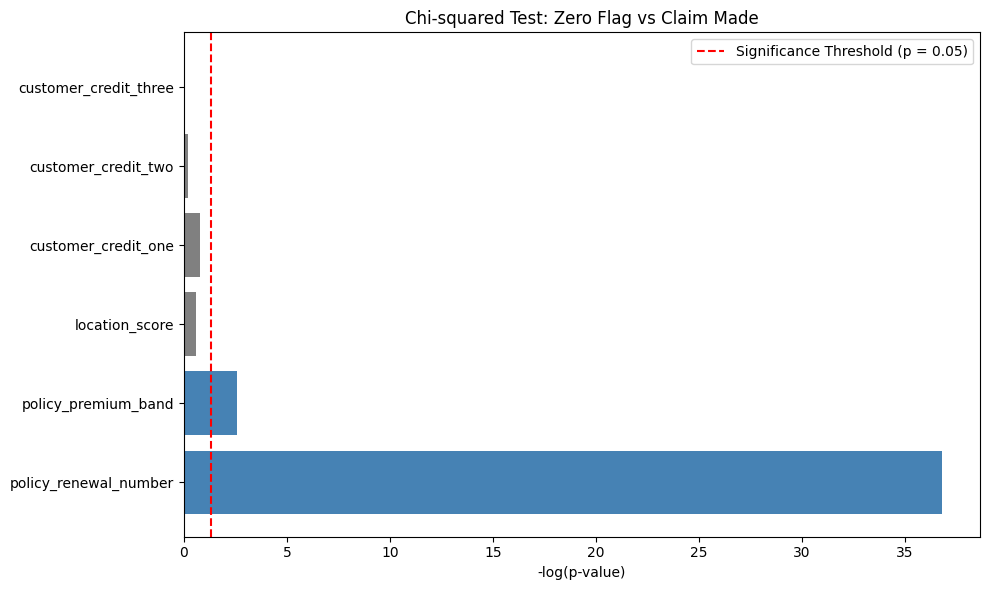

In [9]:
# List of features to test for zero-flag impact on claim rate
zero_features = [
    'policy_renewal_number',
    'policy_premium_band',
    'location_score',
    'customer_credit_one',
    'customer_credit_two',
    'customer_credit_three'
]

# get chi-squared test results for zero flags
chi_results = []
for feature in zero_features:
    result = test_binary_flag_association(df, feature, flag_type='zero', return_values=True)
    chi_results.append(result)

# convert results to DataFrame for easier analysis
chi_df = pd.DataFrame(chi_results, columns=['feature', 'chi2_stat', 'p_value'])

# Add -log10(p-value) so graph is visually interpretable
chi_df['neg_log_p'] = -np.log10(chi_df['p_value'])

# Mark features as statistically significant if p < 0.05
chi_df['is_significant'] = chi_df['p_value'] < 0.05

# Plot results
plt.figure(figsize=(10, 6))
bars = plt.barh(
    chi_df['feature'],
    chi_df['neg_log_p'],
    color=chi_df['is_significant'].map({True: 'steelblue', False: 'grey'})
)

# Add threshold reference line for p = 0.05
plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold (p = 0.05)')

# Axis labels and formatting
plt.xlabel("-log(p-value)")
plt.title("Chi-squared Test: Zero Flag vs Claim Made")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Test 5 Outcome – Do zero values matter?

I ran a chi-squared test on the features we identified to have large volume of zeros to check whether having a zero was statistically associated with claim outcomes.

**Features tested:**
- `policy_renewal_number`
- `policy_premium_band`
- `location_score`
- `customer_credit_one`, `customer_credit_two`, `customer_credit_three`

I created binary flags (e.g., `policy_renewal_number_is_zero`) and ran the test against `claim_made`.

**What I found:**
- Zero values in **`policy_renewal_number`** and **`policy_premium_band`** were **statistically significant** – they do seem to carry some signal related to claims.
- The other features didn’t show a significant relationship – so it’s probably not worth keeping their zero flags.

This doesn’t necessarily mean the binary flag is better than the full feature – but it’s worth trying both during modeling and comparing performance.


---

### Summary of Decisions So Far

- **Target Created:**  
  A new binary column `claim_made` was created based on whether `claim_reported_date` is missing or not.

- **Data Cleaning:**  
  - Dropped exact duplicate rows.  
  - Removed constant columns (`policy_start_date`, `policy_end_date`, `other_policy_flag`).

- **Initial Assumptions:**  
  - Zero values in credit features may represent lack of data (not actual zero score).  
  - `policy_renewal_number == 0` likely indicates a new customer or policy.

- **Missing Data Analysis (Test 1):**  
  - Chi-squared test showed that missingness in `customer_home_ownership` is significantly associated with `claim_made`.  
    → Keep a `home_ownership_missing` flag.  
  - Missingness in `customer_education_level` was **not** significant.  
    → No need to flag or impute specially (yet).

- **Credit Score Ordinality (Test 2):**  
  - No clear increasing or decreasing trend in claim rates across any of the three credit features.  
    → Treat these features as **categorical** or consider **binning** – not ordinal.  
    → Zero flags might be more useful than raw score itself.

- **Binning Policy Features (Test 3):**  
  - Created binned versions of `policy_renewal_number` and `policy_premium_band`.  
  - Binned versions showed clearer trends vs claim rate in plots.  
    → Retain both raw and binned versions for now and compare during modeling.

- **Location Score Zeros (Test 4):**  
  - While `location_score == 0` is common, it does not behave differently in terms of claim rate.  
    → No need to flag `location_score_is_zero`.

- **Zero Value Flags (Test 5):**  
  - Chi-squared test showed that `policy_renewal_number_is_zero` and `policy_premium_band_is_zero` **are** significantly associated with claim rates.  
    → Keep these flags and test if they help in modeling.  
  - Other features' zero flags were **not** significant.  
    → Drop those.

---



**DATA PRE-PROCESSING AND INITIAL LOGISTIC REGRESSION EXPERIMENT SETUP**

In [ ]:



encoding_strategy = {
    "policy_identifier": "drop",  # Unique identifier, no predictive value for modeling.
    "policy_renewal_number": "one-hot",  # Treated as categorical due to non-linear relationship with target.
    "policy_renewal_number_is_zero": "keep",  # Engineered flag shown to be statistically associated with target.
    "renewal_bin": "one-hot",  # Binned version of numeric feature; improves interpretability.
    "policy_premium_band": "one-hot",  # Treated as categorical due to non-linear relationship with target.
    "premium_bin": "one-hot",  # Binned version of numeric feature; improves interpretability.
    "customer_age": "scale",  # Continuous numerical feature; scaling helps logistic regression converge.
    "location_score": "scale",  # Continuous numerical feature with predictive value.
    "location_code": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "market_segment": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "policy_type": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "payment_frequency": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "customer_education_level": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "customer_occupation_sector": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "policy_category_two": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "policy_cover_level": "label",  # Likely ordinal; numeric levels expected to imply increasing coverage.
    "customer_email_verified": "binary",  # Nominal binary variable; one-hot encoding ensures interpretability.
    "payment_method": "binary",  # Binary feature
    "is_joint_policy": "binary",  # Binary feature
    "customer_home_ownership": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "customer_home_ownership_missing": "keep",  # Engineered binary flag; statistically associated with target.
    "customer_credit_one": "label",  # Whilst we found no obvious ordinality - i believe the context of this field being a creditscore -- it should be ordinal and therefore label encoded
    "customer_credit_two": "label",  #  Whilst we found no obvious ordinality - i believe the context of this field being a creditscore -- it should be ordinal and therefore label encoded
    "customer_credit_three": "label",  #  Whilst we found no obvious ordinality - i believe the context of this field being a creditscore -- it should be ordinal and therefore label encoded
    "customer_salary_band": "label",  # Ordinal salary levels; higher bands likely indicate higher income.
    "customer_age_scaled": "drop",  # Duplicate of customer_age; original retained for clarity.
    "customer_gender": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "additional_customer_flag": "binary",  # Binary feature
    "policy_item_category": "one-hot",  # Nominal categorical variable; one-hot encoding avoids false ordering.
    "claim_reported_date": "drop",  # Used to derive the target variable; not needed for modeling.
    "claim_made": "target",  # Binary target indicating whether a claim was made.
}


def run_logistic_experiment(df, encoding_strategy, config, X_train=None, X_test=None, y_train=None, y_test=None):
    ## LLM Generated Docstring!
    """
    Train and evaluate a logistic regression model using flexible encoding strategies and optional custom splits.

    This function supports both default train/test splits and externally provided data splits (e.g., for oversampling).
    It also handles binary, label, one-hot, scaling, and feature retention based on the `encoding_strategy` dict.

    Parameters
    ----------
    df : pandas.DataFrame
        The full input dataset including features and target. Must include 'policy_identifier' if using internal splitting.
    encoding_strategy : dict
        Dictionary mapping feature names to encoding strategies. Valid values include:
        - "drop": drop the feature
        - "one-hot": one-hot encode the feature
        - "scale": standard scale the feature
        - "label": label encode the feature
        - "binary": map binary categories to 0/1
        - "keep": retain feature as-is
        - "target": indicates the target variable (only one allowed)
    config : dict
        Dictionary of model hyperparameters:
        - "class_weight" (default=None): class weighting strategy
        - "solver" (default="saga"): logistic regression solver
        - "max_iter" (default=5000): max iterations
        - "random_state" (default=42): random seed for reproducibility
        - "verbose" (default=True): whether to print evaluation and plots
    X_train, X_test : pandas.DataFrame, optional
        Pre-split training and test feature sets. If not provided, the function performs internal train/test split.
    y_train, y_test : pandas.Series, optional
        Pre-split training and test target sets.

    Returns
    -------
    dict
        Dictionary containing:
        - "model": trained sklearn LogisticRegression object
        - "X_train": encoded training features
        - "X_test": encoded test features
        - "y_train": training labels
        - "y_test": test labels
        - "y_pred": predicted labels for test set
        - "y_proba": predicted probabilities for positive class
        - "policy_ids_train": (if applicable) Series of policy IDs for training set
        - "policy_ids_test": (if applicable) Series of policy IDs for test set

    Notes
    -----
    - If X_train/y_train are provided (e.g. from oversampling), the function skips internal train/test splitting
      and assumes these are ready for training.
    - If using oversampling, ensure the index is reset before passing to avoid lookup errors.
    - The model is intended for binary classification problems.
    - Evaluation includes classification report and confusion matrix if `verbose` is True.
    """
    
    
    
    # CONFIG (.get will default to second argument if not passed to function)
    class_weight = config.get("class_weight", None)
    solver = config.get("solver", "saga")
    max_iter = config.get("max_iter", 5000)
    random_state = config.get("random_state", 42)
    verbose = config.get("verbose", True)

    # Feature Groups 
    policy_ids = df["policy_identifier"].copy()
    one_hot_features = [col for col, strat in encoding_strategy.items() if strat == "one-hot"]
    scale_features = [col for col, strat in encoding_strategy.items() if strat == "scale"]
    label_features = [col for col, strat in encoding_strategy.items() if strat == "label"]
    binary_features = [col for col, strat in encoding_strategy.items() if strat == "binary"]
    keep_features = [col for col, strat in encoding_strategy.items() if strat == "keep"]
    drop_features = [col for col, strat in encoding_strategy.items() if strat == "drop"]
    target_feature = next(col for col, strat in encoding_strategy.items() if strat == "target")

    # Prepare Data 
    X_all = df.drop(columns=drop_features + [target_feature]).copy()
    y_all = df[target_feature].copy()

    if X_train is None or X_test is None or y_train is None or y_test is None:
        not_oversample_experiment = False
    else:
        not_oversample_experiment = True

    if not_oversample_experiment:
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, stratify=y_all, test_size=0.25, random_state=random_state
        )
    else:
        X_train, X_test, y_train, y_test = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

    # manually keep policy id's for later
    
    if not_oversample_experiment:
        policy_ids_train = policy_ids.loc[X_train.index]
        policy_ids_test = policy_ids.loc[X_test.index]



    # Encode Binary Features 
    for col in binary_features:
        # Get sorted unique values from the training data (as strings)
        unique_values = sorted(X_train[col].astype(str).unique())

        # Create a mapping such that the first value becomes 0, second becomes 1
        mapping = {value: idx for idx, value in enumerate(unique_values)}

        # Apply the mapping to both training and test sets
        X_train[col] = X_train[col].astype(str).map(mapping).astype(int)
        X_test[col] = X_test[col].astype(str).map(mapping).astype(int)


    # Label Encode Ordinal Features 
    for col in label_features:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

    # One-Hot Encode Nominal Features 
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_ohe = pd.DataFrame(
        ohe.fit_transform(X_train[one_hot_features]),
        columns=ohe.get_feature_names_out(one_hot_features),
        index=X_train.index
    )
    X_test_ohe = pd.DataFrame(
        ohe.transform(X_test[one_hot_features]),
        columns=ohe.get_feature_names_out(one_hot_features),
        index=X_test.index
    )

    # Scale Continuous Features 
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train[scale_features]),
        columns=scale_features,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test[scale_features]),
        columns=scale_features,
        index=X_test.index
    )

    #  Final Dataset 
    X_train_final = pd.concat([
        X_train_ohe,
        X_train_scaled,
        X_train[label_features + binary_features + keep_features]
    ], axis=1)

    X_test_final = pd.concat([
        X_test_ohe,
        X_test_scaled,
        X_test[label_features + binary_features + keep_features]
    ], axis=1)

    #  Fit Logistic Regression 
    model = LogisticRegression(
        max_iter=max_iter,
        solver=solver,
        penalty='l2',
        class_weight=class_weight,
        random_state=random_state
    )
    model.fit(X_train_final, y_train)

    #  Predict 
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]

    #  Evaluation 
    if verbose:
        print("--- Classification Report ---")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()


    if not_oversample_experiment:

        return {
            "model": model,
            "X_train": X_train_final,
            "X_test": X_test_final,
            "y_train": y_train,
            "y_test": y_test,
            "y_pred": y_pred,
            "y_proba": y_proba,
            "policy_ids_train": policy_ids_train,
            "policy_ids_test": policy_ids_test
        }

    else:
        return {
            "model": model,
            "X_train": X_train_final,
            "X_test": X_test_final,
            "y_train": y_train,
            "y_test": y_test,
            "y_pred": y_pred,
            "y_proba": y_proba,
        }




--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13851
           1       0.98      0.36      0.53       944

    accuracy                           0.96     14795
   macro avg       0.97      0.68      0.75     14795
weighted avg       0.96      0.96      0.95     14795

ROC AUC: 0.9672


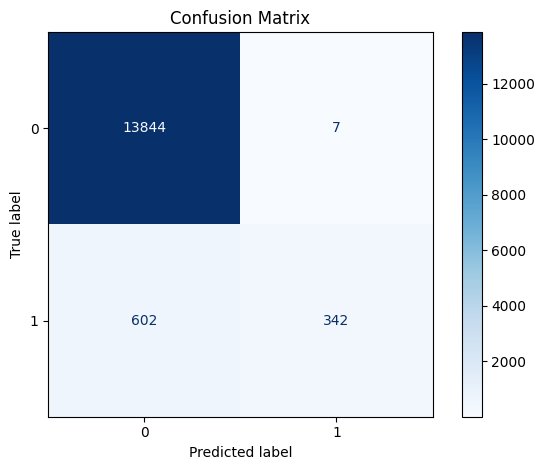

In [11]:
default_config = {
    "name": "Default Logistic",
    "class_weight": None,
    "max_iter": 1000
}

default_experiment = run_logistic_experiment(df, encoding_strategy, default_config)




## The classification report is showing low recall for target class == 1 despite high precision



#### We can try to oversample the data, or we can try to use `"class_weight"` ==`"balanced"` in the logistic regression model. 
- I will experiment both approaches below.








--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     13851
           1       0.33      1.00      0.50       944

    accuracy                           0.87     14795
   macro avg       0.67      0.93      0.71     14795
weighted avg       0.96      0.87      0.90     14795

ROC AUC: 0.9670


C:\Users\james\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


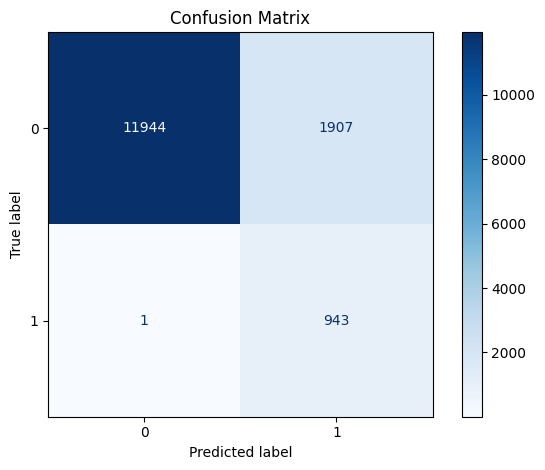

In [12]:
balanced_config = {
    "name": "Balanced Logistic",
    "class_weight": "balanced",
    "max_iter": 1000
}

balanced_experiment = run_logistic_experiment(df, encoding_strategy, balanced_config)

Trying to see if oversampling helps the issue (Important to preserve original testing split to compare results)

If this actually improves the model we must caveat that it has a larger volume of X_train data

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13851
           1       0.98      0.36      0.53       944

    accuracy                           0.96     14795
   macro avg       0.97      0.68      0.75     14795
weighted avg       0.96      0.96      0.95     14795

ROC AUC: 0.9672


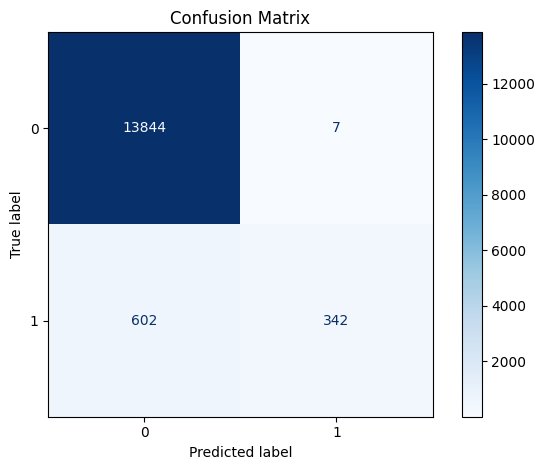

In [17]:


# Identify features
target_feature = next(col for col, strat in encoding_strategy.items() if strat == "target")
drop_features = [col for col, strat in encoding_strategy.items() if strat == "drop"]

# Prepare data 
X = df.drop(columns=drop_features + [target_feature]).copy()
y = df[target_feature].copy()

# Train/test split (original test set preserved) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# Oversample training data only 
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Run experiment with consistent test set 
oversample_config = {
    "name": "Oversampled Logistic",
    "class_weight": None,
    "max_iter": 1000
}

oversampled_experiment = run_logistic_experiment(
    df=df, 
    encoding_strategy=encoding_strategy, 
    config=oversample_config,
    X_train=X_train_resampled,
    X_test=X_test,
    y_train=y_train_resampled,
    y_test=y_test
)


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     13851
           1       0.33      1.00      0.50       944

    accuracy                           0.87     14795
   macro avg       0.67      0.93      0.71     14795
weighted avg       0.96      0.87      0.90     14795

ROC AUC: 0.9670


C:\Users\james\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


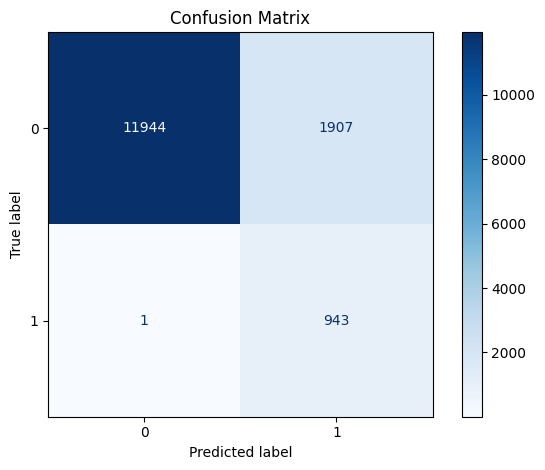

In [18]:
# Run experiment: Oversampled + Class Weight Balanced 
oversample_balanced_config = {
    "name": "Oversampled + Balanced Logistic",
    "class_weight": "balanced",
    "max_iter": 1000
}

oversampled_balanced_experiment = run_logistic_experiment(
    df=df,
    encoding_strategy=encoding_strategy,
    config=oversample_balanced_config,
    X_train=X_train_resampled,
    X_test=X_test,
    y_train=y_train_resampled,
    y_test=y_test
)


## Experiment Summary - Dealing with this imbalanced dataset (Only ~6% of the policies in the data are claimed against)



### Experiment Configurations
| Model                   | Class Weight | Oversampling | Max Iter |
|------------------------|--------------|--------------|----------|
| Default Logistic       | `None`       | No           | 1000     |
| Balanced Logistic      | `'balanced'` | No           | 1000     |
| Oversampled Logistic   | `None`       | Yes          | 1000     |
| Oversampled + Balanced | `'balanced'` | Yes          | 1000     |

### Classification Report Results (focused on **claim class = 1**)
| Metric     | Default | Balanced | Oversampled | Oversampled + Balanced |
|------------|---------|----------|-------------|-------------------------|
| Precision  | 0.98    | 0.33     | 0.33        | 0.33                    |
| Recall     | 0.36    | 1.00     | 1.00        | 1.00                    |
| F1-score   | 0.53    | 0.50     | 0.50        | 0.50                    |
| ROC AUC    | 0.9671  | 0.9668   | 0.9667      | 0.9667                  |
| Accuracy   | 0.96    | 0.87     | 0.87        | 0.87                    |

### My Interpretation (in insurance context)

- **Default model**: High precision, but misses many claims therefore risky if the business wants to avoid underestimating exposure.
- **Balanced weighting**: Catches all potential claimants (recall = 1.0), but at the cost of many false positives.
- **Oversampling** alone doesn't improve recall  so isn’t effective by itself.
- **Balanced + Oversampled** = same result as weighting alone (likely because class_weight overrides any effect of oversampling in logistic regression).

### Outcomes

- For this logistic regression model - oversampling does not perform better than using `class_weight` == `balanced`
- Tradeoff between precision and recall. Must decide which is more important for this context of insurance policy claims.


---

## Now moving on to analysing model coefficients - deciding what features are most important

### Since we have a very large number of features we can directly view the coefficients for logistic regression and cut most of the features that have near-zero weights

#### Note - if i cut features straight away at this stage i might be making a mistake since we have only modeled with logistic regression. Lets try tree based models (specifically XGBoost to observe feature importance and how a modern gradient boosted method performs).


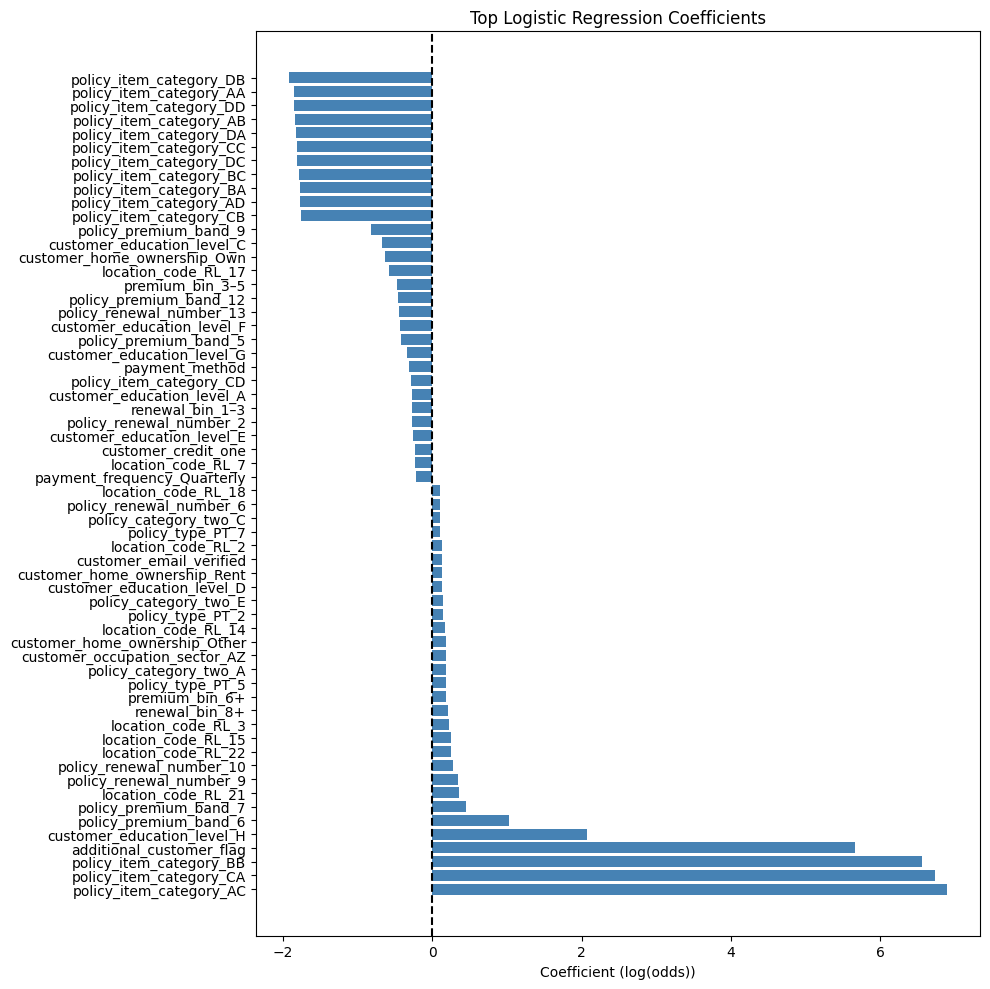

In [19]:
# Unpack from experiment
model = balanced_experiment["model"]
X_train = balanced_experiment["X_train"]
X_test = balanced_experiment["X_test"]
y_train = balanced_experiment["y_train"]
y_test = balanced_experiment["y_test"]
y_pred = balanced_experiment["y_pred"]
y_proba = balanced_experiment["y_proba"]

# Coefficient Inspection
coefs = model.coef_[0]

# Ensure lengths match
assert len(coefs) == len(X_train.columns), "Mismatch between coefficients and feature columns"

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefs
}).sort_values(by='coefficient', ascending=False)

# Select Top Positive & Negative Coefficients
top_n = 30
coef_df_top = pd.concat([
    coef_df.head(top_n),
    coef_df.tail(top_n)
]).sort_values(by='coefficient', ascending=True)  # Sort for better vertical layout

# Coefficient Plot

plt.figure(figsize=(10, 10))
plt.barh(coef_df_top['feature'], coef_df_top['coefficient'], color='steelblue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Top Logistic Regression Coefficients')
plt.xlabel('Coefficient (log(odds))')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Building XGBoost




=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     13851
           1       0.73      0.44      0.55       944

    accuracy                           0.95     14795
   macro avg       0.85      0.71      0.76     14795
weighted avg       0.95      0.95      0.95     14795

ROC AUC: 0.9605


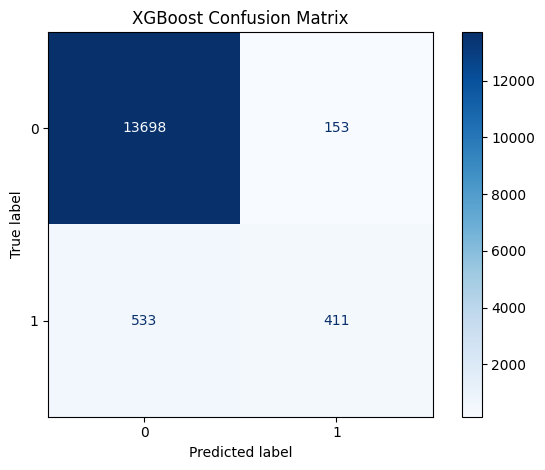

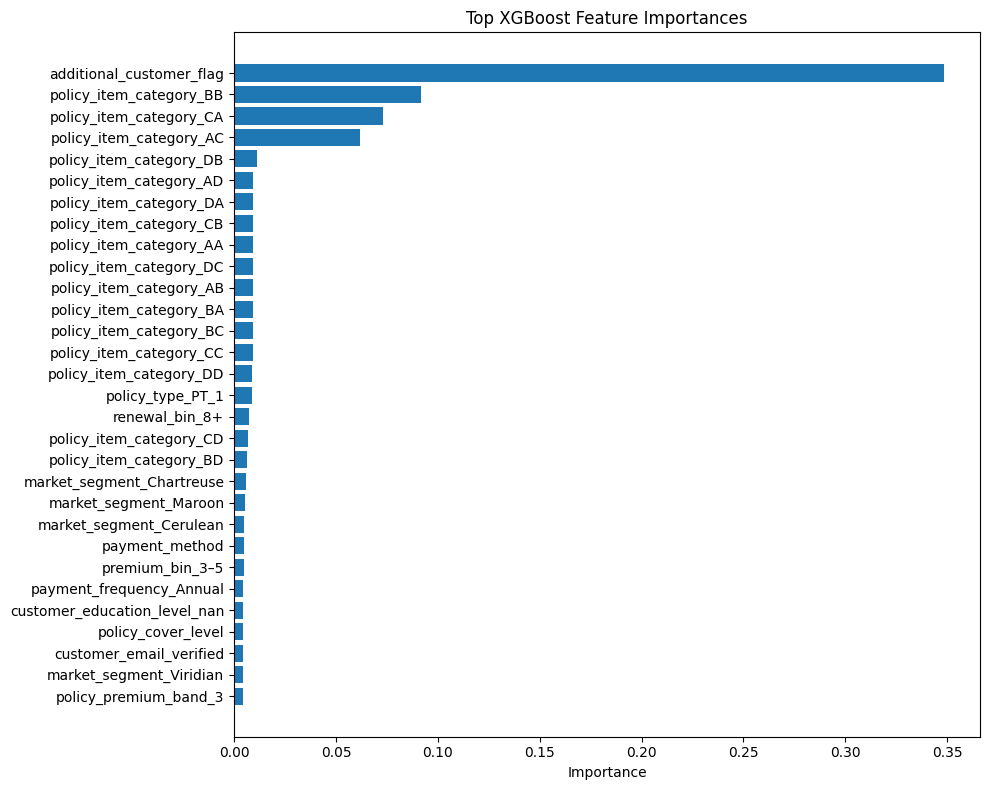

In [20]:



def run_xgboost_experiment(df, encoding_strategy, config={}, X_train=None, X_test=None, y_train=None, y_test=None):
    ## LLM GENERATED DOCSTRING!
    """
    Trains and evaluates an XGBoost classifier using provided data, encoding strategy, and configuration.

    This function supports flexible preprocessing of a mix of categorical and numerical features,
    along with configurable training parameters for the XGBoost model.

    Parameters
    ----------
    df : pandas.DataFrame
        The complete dataset containing features and target variable.
    encoding_strategy : dict
        Dictionary mapping each column to its encoding strategy.
        Accepted values: "one-hot", "label", "binary", "scale", "keep", "drop", "target".
    config : dict, optional
        Configuration for the XGBoost model. Keys can include:
        - "random_state": int, default=42
        - "max_depth": int, default=3
        - "n_estimators": int, default=100
        - "learning_rate": float, default=0.1
        - "scale_pos_weight": float or None, optional class imbalance handling
        - "verbose": bool, default=True
    X_train, X_test : pandas.DataFrame, optional
        Pre-split training and test features. If not provided, a 75/25 split is performed.
    y_train, y_test : pandas.Series, optional
        Pre-split training and test target. Must be binary. If not provided, split is performed.

    Returns
    -------
    dict
        Dictionary containing:
        - "model": trained XGBoost classifier
        - "X_train": preprocessed training features
        - "X_test": preprocessed test features
        - "y_train": training labels
        - "y_test": test labels
        - "y_pred": predicted labels on test set
        - "y_proba": predicted probabilities on test set

    Notes
    -----
    - Handles missing encodings gracefully if `encoding_strategy` is incomplete.
    - Produces a confusion matrix and feature importance chart if `verbose` is True.
    - Suitable for structured tabular binary classification problems.
    """

    # Config
    random_state = config.get("random_state", 42)
    max_depth = config.get("max_depth", 3)
    n_estimators = config.get("n_estimators", 100)
    learning_rate = config.get("learning_rate", 0.1)
    verbosity = config.get("verbose", True)
    scale_pos_weight = config.get("scale_pos_weight", None) 

    

    # Feature Groups
    one_hot_features = [col for col, strat in encoding_strategy.items() if strat == "one-hot"]
    scale_features = [col for col, strat in encoding_strategy.items() if strat == "scale"]
    label_features = [col for col, strat in encoding_strategy.items() if strat == "label"]
    binary_features = [col for col, strat in encoding_strategy.items() if strat == "binary"]
    keep_features = [col for col, strat in encoding_strategy.items() if strat == "keep"]
    drop_features = [col for col, strat in encoding_strategy.items() if strat == "drop"]
    target_feature = next(col for col, strat in encoding_strategy.items() if strat == "target")

    # Prepare Data
    X_all = df.drop(columns=drop_features + [target_feature]).copy()
    y_all = df[target_feature].copy()

    if X_train is None or X_test is None or y_train is None or y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, stratify=y_all, test_size=0.25, random_state=random_state
        )
    else:
        X_train, X_test, y_train, y_test = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

    #Label Encode Ordinal 
    for col in label_features:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

    # Binary Encode
    for col in binary_features:
        classes = sorted(X_train[col].astype(str).unique())
        mapping = {v: i for i, v in enumerate(classes)}
        X_train[col] = X_train[col].astype(str).map(mapping).astype(int)
        X_test[col] = X_test[col].astype(str).map(mapping).astype(int)

    # One-Hot Encode
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_ohe = pd.DataFrame(
        ohe.fit_transform(X_train[one_hot_features]),
        columns=ohe.get_feature_names_out(one_hot_features),
        index=X_train.index
    )
    X_test_ohe = pd.DataFrame(
        ohe.transform(X_test[one_hot_features]),
        columns=ohe.get_feature_names_out(one_hot_features),
        index=X_test.index
    )

    # Scale Features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train[scale_features]),
        columns=scale_features,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test[scale_features]),
        columns=scale_features,
        index=X_test.index
    )

    # Final Dataset
    X_train_final = pd.concat([
        X_train_ohe,
        X_train_scaled,
        X_train[label_features + binary_features + keep_features]
    ], axis=1)

    X_test_final = pd.concat([
        X_test_ohe,
        X_test_scaled,
        X_test[label_features + binary_features + keep_features]
    ], axis=1)

    # XGBoost Model
    model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    random_state=random_state,
    verbosity=1,
    scale_pos_weight=scale_pos_weight if scale_pos_weight is not None else 1
    )


    model.fit(X_train_final, y_train)

    # Predictions
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]

    # Evaluation
    if verbosity:
        print("\n=== XGBoost Classification Report ===")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(cmap="Blues", values_format="d")
        plt.title("XGBoost Confusion Matrix")
        plt.tight_layout()
        plt.show()

        # --- Feature Importance ---
        importance_df = pd.DataFrame({
            "feature": X_train_final.columns,
            "importance": model.feature_importances_
        }).sort_values(by="importance", ascending=False)

        top_n = 30
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df.head(top_n)['feature'][::-1], importance_df.head(top_n)['importance'][::-1])
        plt.title("Top XGBoost Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return {
        "model": model,
        "X_train": X_train_final,
        "X_test": X_test_final,
        "y_train": y_train,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }




xgb_config = {
    "name": "XGBoost Default",
    "max_depth": 8,
    "n_estimators": 100,
    "learning_rate": 0.3,
    "verbose": True
}

xgb_experiment = run_xgboost_experiment(df, encoding_strategy, xgb_config)


## Interpreting the default XGBoost results: 

-- Model has similar trend in low recall for target class == 1 

### Need to include `scale_pos_weight` = 13851 / 944 ≈ 14.67

### (For every positive sample, there are ~14.7 negative ones - so give positives 14.7x more weight in the loss function.)



=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     13851
           1       0.34      0.99      0.50       944

    accuracy                           0.88     14795
   macro avg       0.67      0.93      0.72     14795
weighted avg       0.96      0.88      0.90     14795

ROC AUC: 0.9656


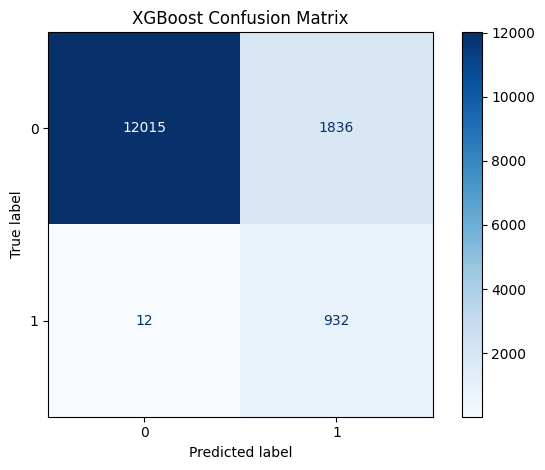

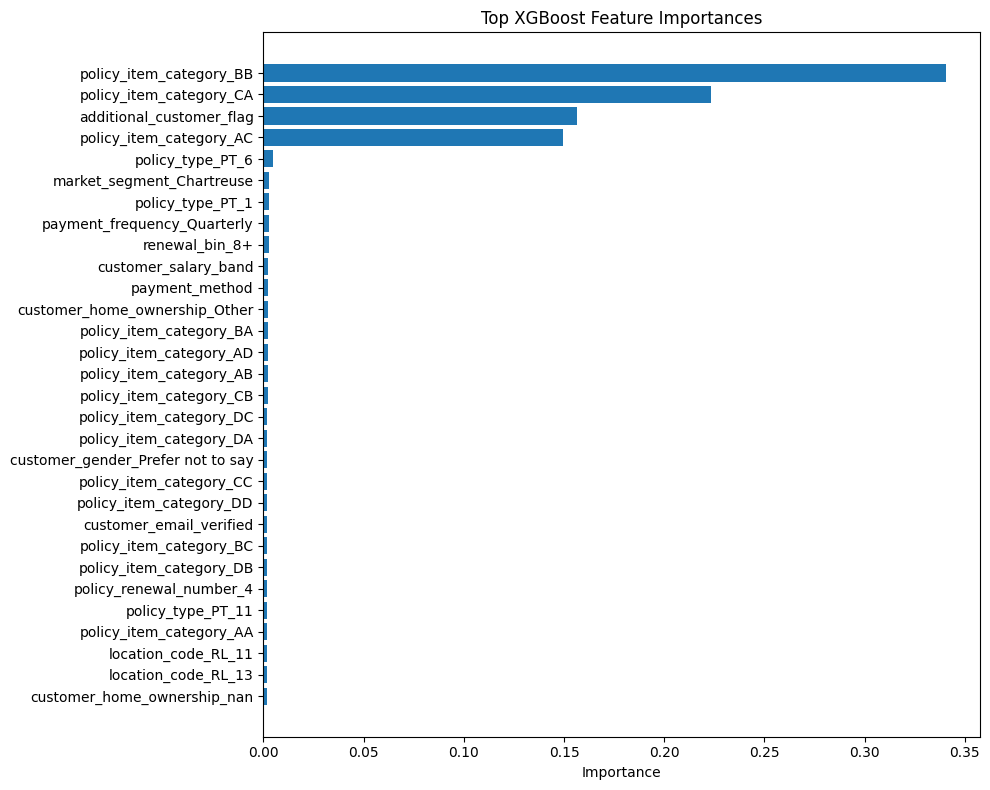

In [24]:
# Config for the experiment
xgb_weighted_config = {
    "name": "XGBoost Weighted",
    "max_depth": 6,
    "n_estimators": 100,
    "learning_rate": 0.1,
    "random_state": 42,
    "scale_pos_weight": (13851 / 944),
    "verbose": True
}

# Run experiment
xgb_weighted_experiment = run_xgboost_experiment(
    df=df,
    encoding_strategy=encoding_strategy,
    config=xgb_weighted_config,
)

## Witnessing the Exact Same Trade-Off from XGBoost as We Did in Logistic Regression

This validates further the idea that we must choose high recall or high precision for class 1 prediction.


## Starting hyper-parameter tuning for xgboost before making any decisions

In [26]:


# Define Parameter Grid
xgb_param_grid = {
    'max_depth': [3, 5, 7, 9,],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, (13851 / 944)],  # No weighting vs class imbalance adjustment
}

X_train_final = xgb_experiment["X_train"]
y_train = xgb_experiment["y_train"]


# Define Model (initial state)
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Scoring Strategy 
# trying to increase both the balance of precision AND recall
scoring = 'recall'  

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring=scoring,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run Tuning
grid_search.fit(X_train_final, y_train)

# Results
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 14.672669491525424}
Best Score: 0.9992941589693002



=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     13851
           1       0.33      1.00      0.50       944

    accuracy                           0.87     14795
   macro avg       0.67      0.93      0.71     14795
weighted avg       0.96      0.87      0.90     14795

ROC AUC: 0.9636


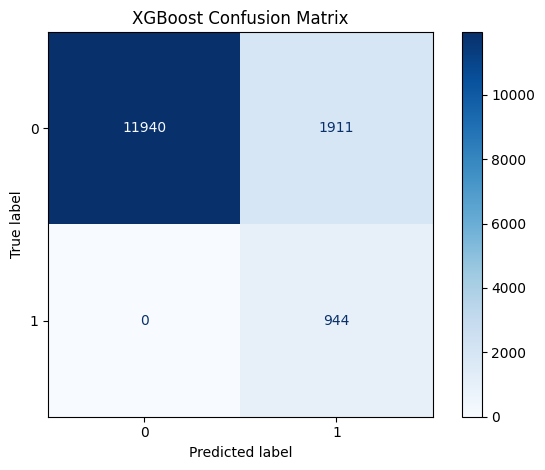

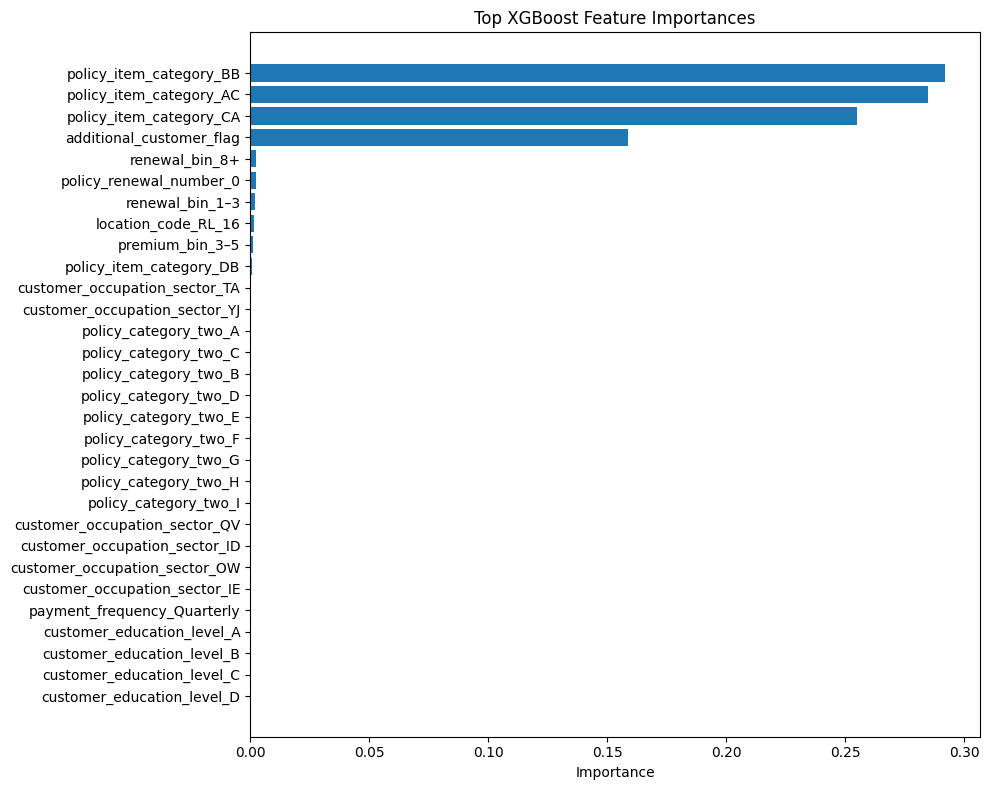

In [27]:
# Best config from hyperparameter tuning
xgb_best_config = {
    "name": "XGBoost Tuned",
    "learning_rate": 0.01,
    "max_depth": 3,
    "n_estimators": 200,
    "scale_pos_weight": (13851 / 944),
    "random_state": 42,
    "verbose": True
}

# Run the experiment
xgb_tuned_experiment = run_xgboost_experiment(
    df=df,
    encoding_strategy=encoding_strategy,
    config=xgb_best_config,
)

###  Model Selection Justification

Model performance is dominated by the feature **`policy_item_type`** in both **Logistic Regression** and **XGBoost**.

 **I will move forward with Logistic Regression**, because:

- **Coefficients are directly explainable**
- It aligns better with the business requirement for **transparency and explainability**

---

###  Moving Forward

- I will now build an **optimised logistic regression model** using everything I’ve learnt so far.
- I will also **prioritise recall**, because in my opinion, for this task it is **more important to screen out high-risk individuals** before selling a policy.
  - **False negatives** (i.e., predicting no claim when one actually occurs) are **more costly** than false positives


In [ ]:

# Define parameter grid
log_reg_param_grid = {
    "solver": ["saga", "liblinear", "lbfgs"],
    "max_iter": [1000, 2000, 10000],
    "C": [0.01, 0.1, 1, 10],
    "class_weight": [None, "balanced"]
}

# Base model
log_reg = LogisticRegression(penalty="l2", random_state=42)

# GridSearchCV
log_reg_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_param_grid,
    scoring="recall", 
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit using your preprocessed training data
log_reg_grid.fit(default_experiment["X_train"], default_experiment["y_train"])

# Best results
print("Best Params:", log_reg_grid.best_params_)
print("Best F1 Score:", log_reg_grid.best_score_)

# Evaluate on test data
best_log_reg = log_reg_grid.best_estimator_
y_pred = best_log_reg.predict(default_experiment["X_test"])
y_proba = best_log_reg.predict_proba(default_experiment["X_test"])[:, 1]


print("\n=== Logistic Regression Classification Report (Tuned) ===")
print(classification_report(default_experiment["y_test"], y_pred))
print(f"ROC AUC: {roc_auc_score(default_experiment['y_test'], y_proba):.4f}")

cm = confusion_matrix(default_experiment["y_test"], y_pred)
ConfusionMatrixDisplay(cm, display_labels=best_log_reg.classes_).plot(cmap="Blues", values_format="d")
plt.title("Logistic Regression Confusion Matrix (Tuned)")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [ ]:
# Unpack model & feature names
model = best_log_reg
X_train = default_experiment["X_train"]

# Coefficients
coefs = model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
}).sort_values(by='abs_coefficient', ascending=False)

# Top N strongest coefficients (positive or negative)
top_n = 30
coef_df_top = pd.concat([
    coef_df.head(top_n),
    coef_df.tail(top_n)
]).drop_duplicates().sort_values(by='coefficient', ascending=True)

# Plot
plt.figure(figsize=(10, 10))
plt.barh(coef_df_top['feature'], coef_df_top['coefficient'], color='steelblue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Top Logistic Regression Coefficients')
plt.xlabel('Coefficient (log-odds)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




# Extract coefficients and compute absolute values
coefs = best_log_reg.coef_[0]
abs_coefs = np.abs(coefs)

# Create DataFrame
coef_dist_df = pd.DataFrame({
    "feature": default_experiment["X_train"].columns,
    "coefficient": coefs,
    "abs_coefficient": abs_coefs
}).sort_values(by="abs_coefficient", ascending=False)

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(coef_dist_df["abs_coefficient"], bins=50, kde=True, color="steelblue", label="Absolute Coefficients")
plt.title("Distribution of Absolute Coefficients")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


## Need a way to help decide where the cutoff is, lets plot a cumiltiive sum of coefficients

# Sort coefficients by absolute value
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df_sorted = coef_df.sort_values(by="abs_coef", ascending=False)

# Calculate cumulative contribution
cumulative_contribution = np.cumsum(coef_df_sorted["abs_coef"]) / coef_df_sorted["abs_coef"].sum()

# Plot cumulative contribution
plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_contribution)), cumulative_contribution, label='Cumulative % of Total Coefficient Magnitude')
plt.axvline(x=40, color='red', linestyle='--', label='Top 40 Features')
plt.xlabel("Feature Rank")
plt.ylabel("Cumulative % of Total Coefficient Magnitude")
plt.title("Cumulative Contribution of Coefficients")
plt.legend()
plt.tight_layout()
plt.show()

model is heavily reliant on a small number of features. We're seeing most of the value in the top 40 features. 

Therefore i am making the decision to retrain with top 40 features. 


In [ ]:

# Use top 40 features from best_log_reg
X_train_full = default_experiment["X_train"]
X_test_full = default_experiment["X_test"]
y_train = default_experiment["y_train"]
y_test = default_experiment["y_test"]

coefs = best_log_reg.coef_[0]
feature_names = X_train_full.columns
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values(by="abs_coef", ascending=False)

top_40_features = coef_df.head(40)["feature"].tolist()

X_train_top40 = X_train_full[top_40_features]
X_test_top40 = X_test_full[top_40_features]

# Retrain Logistic Regression on Top 40
top40_model = LogisticRegression(
    penalty="l2",
    solver=best_log_reg.solver,
    C=best_log_reg.C,
    class_weight=best_log_reg.class_weight,
    max_iter=best_log_reg.max_iter,
    random_state=42
)
top40_model.fit(X_train_top40, y_train)

# Evaluate
y_pred = top40_model.predict(X_test_top40)
y_proba = top40_model.predict_proba(X_test_top40)[:, 1]

print("\n=== Logistic Regression Report (Top 40 Features) ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=top40_model.classes_).plot(cmap="Blues", values_format="d")
plt.title("Logistic Regression Confusion Matrix (Top 40 Features)")
plt.tight_layout()
plt.show()

# Coefficient Plot
coef_top40 = top40_model.coef_[0]
coef_df_top40 = pd.DataFrame({
    "feature": top_40_features,
    "coefficient": coef_top40
}).sort_values(by="coefficient", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(coef_df_top40["feature"], coef_df_top40["coefficient"], color="steelblue")
plt.title("Logistic Regression Coefficients (Top 40 Features)")
plt.xlabel("Coefficient (log odds)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



import pickle

# Save the model to a pickle file
with open("top40_logistic_regression.pkl", "wb") as f:
    pickle.dump(top40_model, f)

print("Model successfully saved to top40_model.pkl")




In [ ]:
# Calculate odds ratio and probability
coef_df_top40["odds_ratio"] = np.exp(coef_df_top40["coefficient"])
# converting log(odds) to isolated probabillities
coef_df_top40["approx_probability"] = coef_df_top40["odds_ratio"] / (1 + coef_df_top40["odds_ratio"])

# Sort by absolute coefficient magnitude
coef_df_top40["abs_coef"] = coef_df_top40["coefficient"].abs()
coef_df_top40.sort_values(by="abs_coef", ascending=False).drop(columns="abs_coef")






## Insights derived from coefficients

| Feature                         | Coefficient   | Odds Ratio  | Approx. Probability | Abs. Coef  | Comments and Plausible Reasonings |
|---------------------------------|---------------|-------------|----------------------|------------|------------------------------------|
| policy_item_category_AC         | 3.4215        | 30.61       | 0.9684               | 3.4215     | Strongest signal of risk. AC policies should be priced carefully and examined further. |
| policy_item_category_CA         | 3.2720        | 26.36       | 0.9635               | 3.2720     | Strong signal of risk. CA policies should be priced carefully and examined further. |
| policy_item_category_BB         | 3.1351        | 22.99       | 0.9583               | 3.1351     | Strong signal of risk. BB policies should be priced carefully and examined further. |
| additional_customer_flag        | 2.2155        | 9.17        | 0.9016               | 2.2155     | If the policy has an additional customer (e.g. spouse), risk increases. May imply shared or higher usage. |
| renewal_bin_8+                 | 0.2345        | 1.26        | 0.5584               | 0.2345     | Customers renewing >8 times are marginally more likely to claim. Possibly more relaxed |
| customer_email_verified         | 0.2141        | 1.24        | 0.5533               | 0.2141     | Slightly higher risk if email is verified  |
| location_code_RL_3             | 0.1224        | 1.13        | 0.5306               | 0.1224     | Region RL_3 has higher claim risk - may require geo-based pricing adjustments. |
| policy_renewal_number_9         | 0.0846        | 1.09        | 0.5211               | 0.0846     | 9th renewal cycle policies are relatively riskier - could reflect policy maturity. |
| customer_home_ownership_Rent    | 0.0808        | 1.08        | 0.5202               | 0.0808     | Renters are slightly more likely to claim than homeowners. Possibly due to lower investment in assets. |
| customer_gender_Female          | -0.0768       | 0.93        | 0.4808               | 0.0768     | Female customers are slightly less likely to claim than male counterparts. |
| market_segment_Chartreuse       | -0.0818       | 0.92        | 0.4796               | 0.0818     | Chartreuse markets are less likely to claim - may reflect demographic or regional behaviors. |
| policy_premium_band_3           | -0.1065       | 0.90        | 0.4734               | 0.1065     | Mid-range premium band shows lower risk. Well-matched pricing likely. |
| location_code_RL_17            | -0.1081       | 0.90        | 0.4730               | 0.1081     | Less risky geography - may be a lower crime or safer zone. |
| location_code_RL_7             | -0.1262       | 0.88        | 0.4685               | 0.1262     | Less risky geography. Regional effect. |
| policy_renewal_number_2         | -0.1331       | 0.88        | 0.4668               | 0.1331     | Small reduction in risk at this renewal age. |
| policy_renewal_number_12        | -0.1428       | 0.87        | 0.4643               | 0.1428     | Small reduction in risk at this renewal age. |
| customer_credit_one             | -0.1466       | 0.86        | 0.4634               | 0.1466     | Higher credit scores via credit_one show less risk - strong predictor. |
| policy_renewal_number_is_zero   | -0.1780       | 0.84        | 0.4556               | 0.1780     | Overlap with other "renewal = 0" indicators. |
| policy_renewal_number_0         | -0.1780       | 0.84        | 0.4556               | 0.1780     | Same as above. Indicates lower risk for new customers. |
| renewal_bin_0                   | -0.1780       | 0.84        | 0.4556               | 0.1780     | New customers show lower risk - potentially better alignment with products. |
| policy_type_PT_6                | -0.1908       | 0.83        | 0.4525               | 0.1908     | This policy type is less risky. Structure/terms may deter claims. |
| policy_category_two_D           | -0.1908       | 0.83        | 0.4525               | 0.1908     | Policy category two "D" indicates lower risk. |
| premium_bin_3–5                 | -0.2374       | 0.79        | 0.4409               | 0.2374     | Mid-tier premium bands show lower claim risk - good pricing alignment. |
| policy_cover_level              | -0.2515       | 0.78        | 0.4375               | 0.2515     | Higher cover level buyers tend to be more risk-averse - fewer claims. |
| renewal_bin_1–3                 | -0.2532       | 0.78        | 0.4370               | 0.2532     | Early renewals indicate responsible customer base. |
| payment_frequency_Quarterly     | -0.3447       | 0.71        | 0.4147               | 0.3447     | Lower claims among quarterly payers - suggests structured, disciplined segments. |
| payment_method                  | -0.5782       | 0.56        | 0.3594               | 0.5782     | Payment method "X" is associated with much lower risk than counterpart. |
| policy_item_category_BD         | -0.7430       | 0.48        | 0.3223               | 0.7430     | Strong indicator of lower risk for product BD. |
| policy_item_category_CD         | -0.7883       | 0.45        | 0.3125               | 0.7883     | Strong indicator of lower risk for product CD. |
| policy_item_category_BC         | -0.8062       | 0.45        | 0.3087               | 0.8062     | Strong indicator of lower risk for product BC. |
| policy_item_category_CC         | -0.8128       | 0.44        | 0.3073               | 0.8128     | Strong indicator of lower risk for product CC. |
| policy_item_category_DD         | -0.8138       | 0.44        | 0.3071               | 0.8138     | Strong indicator of lower risk for product DD. |
| policy_item_category_DC         | -0.8142       | 0.44        | 0.3070               | 0.8142     | Strong indicator of lower risk for product DC. |
| policy_item_category_CB         | -0.8154       | 0.44        | 0.3067               | 0.8154     | Strong indicator of lower risk for product CB. |
| policy_item_category_DB         | -0.8164       | 0.44        | 0.3065               | 0.8164     | Strong indicator of lower risk for product DB. |
| policy_item_category_AA         | -0.8179       | 0.44        | 0.3062               | 0.8179     | Strong indicator of lower risk for product AA. |
| policy_item_category_BA         | -0.8205       | 0.44        | 0.3057               | 0.8205     | Strong indicator of lower risk for product BA. |
| policy_item_category_AD         | -0.8208       | 0.44        | 0.3056               | 0.8208     | Strong indicator of lower risk for product AD. |
| policy_item_category_AB         | -0.8218       | 0.44        | 0.3054               | 0.8218     | Strong indicator of lower risk for product AB. |
| policy_item_category_DA         | -0.8311       | 0.44        | 0.3034               | 0.8311     | Strong indicator of lower risk for product DA. |



---

## Sorting the testing dataset by the `y_proba` field and ranking customers based on predicted risk. 

## This will allow us to analyse a threshold to understand the top 95% safest customers. 

## The goal is to sell policies only to the 95% of customers least likely to make a claim

In [ ]:
# Combine predictions with true outcomes
df_model_outputs = pd.DataFrame({
    "proba": best_log_reg.predict_proba(X_test)[:, 1],
    "true": y_test
})

# Sort by predicted probability
df_policy_analysis = df_model_outputs.sort_values(by="proba")

# Add policy_identifier to df_policy_analysis
policy_ids_test = df.loc[y_test.index, "policy_identifier"].astype(str)
df_policy_analysis["policy_identifier"] = policy_ids_test.loc[df_policy_analysis.index].values.astype(str)

# Ensure df_original also has string type identifier
df_original["policy_identifier"] = df_original["policy_identifier"].astype(str)

# Merge to get full customer data back
df_policy_analysis = pd.merge(
    df_policy_analysis,
    df_original,
    on="policy_identifier",
    how="left"
)

# Compute 95th percentile threshold
threshold = df_policy_analysis["proba"].quantile(0.95)
print(f"Selected threshold: {threshold:.4f}")

# Tag whether to sell policy or not
df_policy_analysis["sell_policy"] = df_policy_analysis["proba"] <= threshold


## Compares all the distributions of policies that we flagged as to sell vs not

# # Define real features to plot
# plot_features = [
#     col for col, strat in encoding_strategy.items()
#     if strat not in ["drop", "target", "keep"] and col in df_policy_analysis.columns
# ]

# # Split by encoding type
# categorical_strats = ["one-hot", "binary"]
# numerical_strats = ["scale", "label"]

# categorical_features = [f for f in plot_features if encoding_strategy[f] in categorical_strats]
# numerical_features = [f for f in plot_features if encoding_strategy[f] in numerical_strats]

# # --- Plot Numerical ---
# for col in numerical_features:
#     plt.figure(figsize=(6, 4))
#     sns.kdeplot(data=df_policy_analysis, x=col, hue="sell_policy", common_norm=False, fill=True)
#     plt.title(f"Distribution of {col} by Sell Policy Decision")
#     plt.xlabel(col)
#     plt.ylabel("Density")
#     plt.tight_layout()
#     plt.show()

# # --- Plot Categorical ---
# for col in categorical_features:
#     if df_policy_analysis[col].nunique() > 20:
#         continue  # Skip high cardinality
#     plt.figure(figsize=(7, 4))
#     dist = pd.crosstab(df_policy_analysis[col], df_policy_analysis["sell_policy"], normalize='index')
#     dist.plot(kind='bar', stacked=True, colormap="coolwarm", width=0.8)
#     plt.title(f"Sell Policy Rate by {col}")
#     plt.ylabel("Proportion of Customers")
#     plt.xlabel(col)
#     plt.legend(title="Sell Policy")
#     plt.tight_layout()
#     plt.show()

We can now profile the policies that we have calculated would be too risky if we want a total claim rate of 5% across the business' customer base.

In [ ]:
df_risky_policies = df_preds_sorted[df_preds_sorted['sell_policy']==False]

# Create profile report
profile = ProfileReport(df_risky_policies, title="Risky Policies Profile Report", explorative=True)

# Optionally, export to an HTML file for sharing
profile.to_file("risky_policies_profile.html")


## Summary of what I did

- Loaded the data and ran a profiling tool to explore it quickly  
- Took a "problem-first" approach: cleaned duplicates, handled missing values, zeros, and imbalance  
- Explored the impact of zero-heavy features and tested some fixes  
- Designed a feature-by-feature encoding strategy - mostly categorical fields  
- Built a baseline logistic regression model for its interpretability  
- Evaluated performance and tried handling target imbalance  
- Also tested XGBoost, but stuck with logistic regression (same performance, better insights)  
- Analysed model coefficients to extract business insights  
- Built a thresholding method to flag the riskiest 5% of policies  
- Profiled the riskiest group for further business action

---

## If I had more time

- Would’ve analysed combinations of features for deeper patterns  
- Could’ve done more feature engineering (esp. combining weaker OHE features)  
- SHAP on XGBoost would’ve been useful - but not needed once I committed to logistic regression


## Results Conclusion

The final logistic regression model performed well overall, hitting **87% accuracy** and an **AUC of 0.966**. That means it can distinguish between claimants and non-claimants with high confidence. That said, the **F1 score for claimants topped out around 0.50**, which highlights the challenge of working with an imbalanced target. Improving that score would require more data and potentially deeper feature engineering.

I optimised the model for **recall**, as missing risky customers (false negatives) would be more damaging to the business than being overly cautious. With this trade-off, the model correctly identifies nearly all potential claims.

One of the key outputs was the ability to flag the **top 5% riskiest policies** using model probability. These "don’t sell" cases had a **claim rate over 60%**, compared to the baseline of ~3%. That makes them stand out as meaningful high-risk policies that warrant attention - either to be declined, priced higher, or examined further.

Across the top 40 features, we saw that customer and product attributes strongly influence risk. For example:
- Policies covering certain items (like category AC or CA) had **30x higher odds** of a claim.
- Customers with additional policyholders were **9x more likely** to claim.
- Risk was also shaped by credit score, home ownership, payment method, and location.

From these insights, the business can begin to shape smarter pricing strategies or improve pricing or customer acquisition stratergy. The model isn’t perfect, but it’s directional and actionable.

If taken further, we could:
- Investigate feature interactions (e.g. location × product type),
- Engineer new aggregated features,
- Package the model into an API,
- And develop a monitoring plan to flag model drift over time.

This notebook documents the end-to-end process, from raw data through to deployable logic , in a way that is both interpretable and repeatable.



# Questions
### The following questions are to understand how you would account for the solution outside of the developed model. Please include written answers to these questions in your response, either within your notebook, or in a separate document (preferably in a markdown or word editor format, e.g. .md or .docx).
- **Assuming the business likes your model, what are the next steps to go from the Jupyter Notebook you've created to a productionised service?**

  - This notebook serves as an exploratory and experimental environment where I’ve documented the decisions and steps I’ve taken to arrive at a working model. Assuming the business is happy with the current outputs, the next step would be to refactor this work into a proper production-ready pipeline - something more structured, testable, and optimised.

  - Once the code is modularised and cleaned up, the model can be saved (as I’ve already demonstrated in the notebook using pickle) and deployed behind a REST API - this could be built using Flask, FastAPI, or even a cloud-native solution like Azure Functions or Databricks, depending on the infrastructure and requirements. Containerising the model (e.g., using Docker) is a common next step, especially if we want to ensure portability and consistency in deployment.

  - In terms of experience: yes, I’ve done something similar in a previous role at HSBC, where I was responsible for maintaining a Flask-based API that powered a global internal web app. This wasn’t a machine learning model, but rather a Python-based data profiling tool that allowed users to upload files like PDFs for OCR-style analysis. I worked alongside EY consultants to help build this initially, but eventually took over the platform myself - I became the main point of contact for maintaining and enhancing it. The project was hosted through Jenkins CI/CD, and that gave me good exposure to how deployment pipelines work in a large enterprise, as well as the responsibilities involved in keeping a tool live and performant for many users.

  - If i have your permission to host this end-point on a public domain (my own personal website) I could demonstrate a real-time form based front end that will give a direct probabillity of a claim within a year given sign-up values entered in a website form. Let me know if this is something you would like to see. 






- **What considerations are the for ensuring that if you productionised this model, the business could leverage it?**
   - If the business wanted to take this model live, there are a few important things that need to be thought about upfront to make sure it would actually work in practice.

   - One of the biggest concerns is model drift - over time, the data going into the model might change (e.g. customer behaviour, policy structure, external market factors), which could lead to the model making worse predictions. If we’re using this model to guide decisions like who to sell policies to, we need to make sure the performance holds up. So I’d recommend putting monitoring in place to track things like changes in input data distributions, model confidence, and the actual claim rate over time. If any of that starts to shift, we’d need to retrain or even revisit the model entirely.

   - Another thing is making sure the data pipeline is stable. All the features we used in this model have to be available at the time a prediction is made - and they need to be encoded and handled the same way as in training. So we'd need to productionise the full preprocessing pipeline as well, ideally in a way that’s version-controlled and tested.

   - There’s also a practical side. Who owns the model once it goes live? Someone needs to keep an eye on it, monitor performance, and have a process for updating or re-deploying it. That means documenting everything properly and ideally automating things like retraining, evaluation, and deployment.

   - Since this model makes real decisions (i.e. whether or not to sell a policy), we also have to think about explainability. One of the reasons I went with logistic regression was because it’s easy to explain - you can directly interpret the coefficients. But in a live system, we’d still want some way to log why a prediction was made and surface that in a way the business can understand.

   - Finally, it’s not just about the model - it’s about how it fits into the actual business workflow. Where does this model get used? Is it embedded in a sales tool? Will someone be reviewing the decision, or is it automatic? Do we want to allow manual overrides? All of these things need to be worked out with the wider business so that the model actually adds value and doesn’t create friction.
- What are the steps you would take to provide this to the business? What assumptions are you making for this to be possible?
  - In my experiance working in finance, there are often SME's that exist in the business that are highly knowledgeable about subsets of policies/customers that can tell you business domain knowledge that is hard to see through the lense of data exploration. For example, sometimes the data in ERP systems can present a meaningfull pattern or insight but in reality the data cannot be relied upon as the golden source of the truth. This exercise has me assume that the input data is the correct data to be using, however in my experiance this is almost always a really important part of any data related project. It's imperetive that in the planning phase of any modeling or analysis work that will be used to make real decisions, you must seek validation and SME opinion on data sources/ data approach when evaluating the data that is available. This is especially true in a highly regulated field like insurance and i would take deliberate care in early decisioning around data sources by raising questions early and often.

  - We are assuming that we will have stakeholder buy-in if we are able to demonstrate clear insights from our model. This may not be the case, and the success of a project like this could depend on how quickly you can extract proven value from a model. Thats taking  data level analysis all the way to actionable decisions with the right people. This may happen by demonstrating key patterns in your work and presenting insights that can be proven to be real over time. Managing expectations with stakeholders is one of the biggest learning experiances I have had since I have started my career in data and i believe communication skills should be a life long learning exercise for a career in this field. 

  - Some realistic first steps i would take to moving this from development to outcome would be to develop a project plan on deployment, a period of hypercare, responsibillities during hypercare and BAU thereafter. I would ensure this plan was reviewed by the wider data science team and the key stakeholders that will be impacted by this work. This plan will highlight areas that require input from the wider team such as controls, who is responsible for which areas of the pipeline and removing any key person dependencies for safety around annual leave periods. 

  





- Assuming that the team you're working in only consists of data scientists, which other teams in the business would you need to speak to?
    - If it's just data scientists in the team, there are still a few other areas of the business I’d need to speak to in order to make sure the model actually gets used properly and can be trusted.

    - I’d start with whoever manages the production infrastructure or platform engineering side of things. Even if there's no formal DevOps team, I’d look to handle deployment myself with something like Flask or FastAPI, containerised with Docker and hosted on Azure or AWS. But it’s still important that the platform or IT team is aware so that things like security, scaling and monitoring are all handled properly.

    - Then there’s the product or business operations teams. They’re going to be the ones actually using the model outputs, so I’d want to make sure the decisions the model helps with actually make sense in context. That includes things like checking the thresholds work for their risk appetite and making sure they understand what the model is doing.

    - I’d also check in with legal and compliance, since we’re talking about a model that affects whether someone gets offered a policy or not. We need to make sure we’re not introducing any bias or doing anything that might fall foul of regulation.

    - Lastly, I’d want to align with whoever owns the data from a governance point of view. That way we can make sure all the inputs are properly defined and stable, and that we’re not relying on features that could disappear or change meaning over time.


- What is in scope and out of scope for your responsibility?
    - Ideally this would be defined in the planning / requirements gathering stage of a project. However in reality big projects often have moving scope and deliverables, its important to communicate often where possible. 

    - Generally what is out of scope will depend on the level of technical skills that the business operations team has. What is the agreement from a department perspective? I dont think anything is inherently out of scope by default except where i do not have the skillset to complete the tasks. For example- if we needed a legal review i could not perform that and should ensure that it's completed by the correct person.


